## Problem Description

Myocardial Infarction (MI), commonly known as a heart attack, is a life-threatening condition caused by the blockage of blood flow to the heart muscle. Early detection is critical for effective treatment. This project focuses on the automated classification of ECG signals into Normal and MI classes using machine learning techniques.

## Dataset Description

The datasets were sourced from PhysioNet:

### 1. PTB Diagnostic ECG Database (PTBDB)
- Contains 368 ECG recordings from MI patients.
- Sampling Frequency: 1000 Hz.
- Multi-lead ECG signals.
- Used 1 lead per patient.
- Selected: 368 MI samples, 80 Healthy samples.

### 2. MIT-BIH Normal Sinus Rhythm Database (NSRDB)
- Contains 500 ECG recordings from healthy individuals.
- Sampling Frequency: 128 Hz.

### Combined Dataset
- MI: 368 samples (from PTBDB).
- Healthy: 80 samples (from PTBDB).
- Additional Normal: 500 samples (from NSRDB).
- Total samples: 368 (MI) + 80 (Healthy PTBDB) + 500 (Healthy NSRDB) = 948 samples.

## Preprocessing

### Sampling Rate Adjustment
- Signals were resampled using `scipy.signal.resample_poly()` to ensure consistent frequency and length.
- PTBDB: Downsampled from 1000 Hz to 500 Hz.
- NSRDB: Upsampled from 128 Hz to 500 Hz.
- Final unified sampling rate: **500 Hz**.
- Fixed signal length: **2500 samples**.

### Wavelet Transform
- Applied **Discrete Wavelet Transform (DWT)** using `sym4` wavelet at level 3.
- Extracted **approximation coefficients** to retain essential ECG features and reduce high-frequency noise.

### DNN

- 1D CNNs are effective for time-series data like ECG signals, as they capture local temporal features such as QRS complexes, P and T waves. In this project, the 1D CNN is used to distinguish between ECGs of patients with Myocardial Infarction (MI) and healthy individuals.



## Data Rendering and Preprocessing

-> Separating MI and Healthy patients

In [1]:
#%pip install wfdb #waveform database used for physiological signals

# It was originally developed for handling data from PhysioNet

In [2]:
import wfdb
import pandas as pd
import numpy as np
import os

In [3]:
#wfdb.dl_database('ptbdb', dl_dir='ptbdb_data') #data for each patient from ptbdb dataset

In [4]:

#wfdb.dl_database('nsrdb', dl_dir='nsrdb_data')

In [5]:
data_path = "ptbdb_data"
records_mi = []

for patient_folder in os.listdir(data_path):
    patient_path = os.path.join(data_path, patient_folder)
    if os.path.isdir(patient_path):
        for record in os.listdir(patient_path):
            if record.endswith('.hea'):
                record_path = os.path.join(patient_path, record[:-4])
                try:
                    rec = wfdb.rdrecord(record_path)
                    ann = wfdb.rdheader(record_path)

                    # if comments = "Myocardial Infraction" then label = 1
                    for comment in ann.comments:
                        if "Myocardial infarction" in comment:
                            label = 1
                            break
                    else:
                        label = 0

                    # get lead II or first available lead
                    if "II" in rec.sig_name:
                        idx = rec.sig_name.index("II")
                    else:
                        idx = 0

                    signal = rec.p_signal[:, idx]

                    records_mi.append({
                        "record": record_path,
                        "signal": signal,
                        "label": label,
                        "lead": rec.sig_name[idx]
                    })
                except Exception as e:
                    print(f"Error with {record_path}: {e}")


In [6]:
data_path = "ptbdb_data"
healthy_ptbdb = []

for main_dir in os.listdir(data_path):
    patient_path = os.path.join(data_path, main_dir)
    
    if os.path.isdir(patient_path):
        for record in os.listdir(patient_path):
            if record.endswith('.hea'):
                record_path = os.path.join(patient_path, record[:-4])
                
                try:
                    ann = wfdb.rdheader(record_path)

                    # Check if "Healthy control" is in comments
                    if not any("Healthy control" in comment for comment in ann.comments):
                        continue  # Skip non-healthy records

                    rec = wfdb.rdrecord(record_path)

                    # Use Lead II if available, else fallback to first lead
                    if "II" in rec.sig_name:
                        idx = rec.sig_name.index("II")
                    else:
                        idx = 0

                    signal = rec.p_signal[:, idx]

                    healthy_ptbdb.append({
                        "record": record_path,
                        "signal": signal,
                        "label": 0,
                        "lead": rec.sig_name[idx]
                    })

                except Exception as e:
                    print(f"Error with {record_path}: {e}")


In [7]:
df_healthy = pd.DataFrame(healthy_ptbdb)
#print(df_healthy[['record', 'label', 'lead']]).head() #extracted healthy persons data form ptbdb

df_healthy

,record,signal,label,lead
0,ptbdb_data\patient104\s0306lre,"[0.031, 0.029, 0.03, 0.0275, 0.0295, 0.033, 0....",0,i
1,ptbdb_data\patient105\s0303lre,"[-0.658, -0.66, -0.6575, -0.652, -0.643, -0.63...",0,i
2,ptbdb_data\patient116\s0302lre,"[-2.0885, -2.0925, -2.089, -2.091, -2.095, -2....",0,i
3,ptbdb_data\patient117\s0291lre,"[-0.1775, -0.1715, -0.174, -0.1735, -0.17, -0....",0,i
4,ptbdb_data\patient117\s0292lre,"[0.0445, 0.0465, 0.054, 0.0555, 0.0525, 0.0555...",0,i
...,...,...,...,...
75,ptbdb_data\patient279\s0533_re,"[-0.3755, -0.3725, -0.375, -0.371, -0.3705, -0...",0,i
76,ptbdb_data\patient279\s0534_re,"[-0.084, -0.0845, -0.088, -0.0885, -0.0915, -0...",0,i
77,ptbdb_data\patient284\s0543_re,"[-0.1915, -0.1895, -0.1935, -0.1955, -0.2005, ...",0,i
78,ptbdb_data\patient284\s0551_re,"[2.4475, 2.446, 2.4435, 2.45, 2.448, 2.444, 2....",0,i


In [ ]:
df_mi = pd.DataFrame(records_mi)

In [9]:
#adding signals into the dataframe

os.makedirs("signals", exist_ok=True)

for i, row in df_mi.iterrows():
    rec = wfdb.rdrecord(row['record'])
    lead_idx = rec.sig_name.index(row['lead'])
    signal = rec.p_signal[:, lead_idx]
    np.save(f"signals/{i}.npy", signal)

In [10]:
df_mi

,record,signal,label,lead
0,ptbdb_data\patient001\s0010_re,"[-0.2445, -0.2425, -0.2415, -0.241, -0.2315, -...",1,i
1,ptbdb_data\patient001\s0014lre,"[-0.474, -0.444, -0.4555, -0.462, -0.459, -0.4...",1,i
2,ptbdb_data\patient001\s0016lre,"[0.254, 0.263, 0.2755, 0.28, 0.3035, 0.305, 0....",1,i
3,ptbdb_data\patient002\s0015lre,"[0.2735, 0.287, 0.2925, 0.312, 0.3275, 0.3305,...",1,i
4,ptbdb_data\patient003\s0017lre,"[-0.6195, -0.6225, -0.626, -0.6275, -0.626, -0...",1,i
...,...,...,...,...
544,ptbdb_data\patient292\s0555_re,"[-0.5035, -0.516, -0.525, -0.508, -0.5035, -0....",1,i
545,ptbdb_data\patient292\s0556_re,"[0.8055, 0.809, 0.831, 0.834, 0.831, 0.857, 0....",1,i
546,ptbdb_data\patient293\s0557_re,"[-1.1685, -1.644, -2.0055, -1.8375, -1.833, -1...",1,i
547,ptbdb_data\patient293\s0558_re,"[0.6085, 0.6145, 0.6275, 0.6305, 0.617, 0.62, ...",1,i


In [11]:
#adding signals to the healthy data also
os.makedirs("signals_healthy", exist_ok=True)

for i, row in df_healthy.iterrows():
    rec = wfdb.rdrecord(row['record'])
    lead_idx = rec.sig_name.index(row['lead'])
    signal = rec.p_signal[:, lead_idx]
    np.save(f"signals_healthy/{i}.npy", signal)

In [12]:
df_healthy

,record,signal,label,lead
0,ptbdb_data\patient104\s0306lre,"[0.031, 0.029, 0.03, 0.0275, 0.0295, 0.033, 0....",0,i
1,ptbdb_data\patient105\s0303lre,"[-0.658, -0.66, -0.6575, -0.652, -0.643, -0.63...",0,i
2,ptbdb_data\patient116\s0302lre,"[-2.0885, -2.0925, -2.089, -2.091, -2.095, -2....",0,i
3,ptbdb_data\patient117\s0291lre,"[-0.1775, -0.1715, -0.174, -0.1735, -0.17, -0....",0,i
4,ptbdb_data\patient117\s0292lre,"[0.0445, 0.0465, 0.054, 0.0555, 0.0525, 0.0555...",0,i
...,...,...,...,...
75,ptbdb_data\patient279\s0533_re,"[-0.3755, -0.3725, -0.375, -0.371, -0.3705, -0...",0,i
76,ptbdb_data\patient279\s0534_re,"[-0.084, -0.0845, -0.088, -0.0885, -0.0915, -0...",0,i
77,ptbdb_data\patient284\s0543_re,"[-0.1915, -0.1895, -0.1935, -0.1955, -0.2005, ...",0,i
78,ptbdb_data\patient284\s0551_re,"[2.4475, 2.446, 2.4435, 2.45, 2.448, 2.444, 2....",0,i


In [13]:
#Extracting the healthy persons data from nsrdb dataset

data_path = 'nsrdb_data'
segment_duration_sec = 10         # segment length in seconds
sampling_rate = 128               # nsrdb is 128 Hz
segment_length = segment_duration_sec * sampling_rate

nsr_records = []

for file in os.listdir(data_path):
    if file.endswith('.hea'):
        record_name = file[:-4]
        record_path = os.path.join(data_path, record_name)

        try:
            rec = wfdb.rdrecord(record_path)
            leads = rec.sig_name

            # Prefer MLII, else take lead 0
            if "MLII" in leads:
                lead_idx = leads.index("MLII")
            else:
                lead_idx = 0

            signal = rec.p_signal[:, lead_idx]

            # Segment the signal into fixed windows
            total_segments = len(signal) // segment_length
            for i in range(total_segments):
                start = i * segment_length
                end = start + segment_length
                segment = signal[start:end]

                nsr_records.append({
                    "record": record_path,
                    "signal": segment,
                    "label": 0,
                    "lead": leads[lead_idx],
                    "source": "nsrdb"
                })

        except Exception as e:
            print(f"[NSRDB Error] {record_path}: {e}")

df_nsr_total = pd.DataFrame(nsr_records)
print(f"Extracted {len(df_nsr_total)} normal ECG segments from NSRDB")

Extracted 157491 normal ECG segments from NSRDB


In [14]:
df_nsr_total

,record,signal,label,lead,source
0,nsrdb_data\16265,"[-0.165, -0.155, -0.195, -0.205, -0.185, -0.15...",0,ECG1,nsrdb
1,nsrdb_data\16265,"[-0.145, -0.125, -0.145, -0.155, -0.165, -0.14...",0,ECG1,nsrdb
2,nsrdb_data\16265,"[-0.135, -0.155, -0.135, -0.135, -0.175, -0.15...",0,ECG1,nsrdb
3,nsrdb_data\16265,"[0.865, 2.475, 2.885, 2.485, 0.995, -0.215, -0...",0,ECG1,nsrdb
4,nsrdb_data\16265,"[-0.175, -0.155, -0.155, -0.205, -0.125, -0.09...",0,ECG1,nsrdb
...,...,...,...,...,...
157486,nsrdb_data\19830,"[0.0, 0.0, 0.0, 0.0, -0.01, -0.01, -0.01, -0.0...",0,ECG1,nsrdb
157487,nsrdb_data\19830,"[0.0, -0.01, 0.0, -0.01, 0.0, -0.01, -0.01, -0...",0,ECG1,nsrdb
157488,nsrdb_data\19830,"[-0.07, -0.07, -0.07, -0.07, -0.07, -0.07, -0....",0,ECG1,nsrdb
157489,nsrdb_data\19830,"[-0.11, -0.11, -0.1, -0.11, -0.11, -0.11, -0.1...",0,ECG1,nsrdb


In [15]:
#since there are 157491 rows entries i want to just keep 500 enteries from nsrdb dataset
df_healthy_nsrdb = df_nsr_total.drop(columns=['source'], errors='ignore') #ignoring the last column

df_nsr = df_healthy_nsrdb.sample(n=500, random_state=42)
df_nsr

,record,signal,label,lead
84043,nsrdb_data\17052,"[1.585, 0.485, -0.715, -0.505, -0.165, -0.105,...",0,ECG1
14556,nsrdb_data\16272,"[-0.055, -0.055, -0.045, -0.045, -0.045, -0.04...",0,ECG1
122955,nsrdb_data\19088,"[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0....",0,ECG1
92620,nsrdb_data\17453,"[-0.095, -0.085, -0.135, -0.125, -0.155, -0.15...",0,ECG1
96706,nsrdb_data\17453,"[-0.07, -0.08, -0.07, -0.07, -0.07, -0.07, -0....",0,ECG1
...,...,...,...,...
19031,nsrdb_data\16273,"[-0.045, -0.045, -0.065, -0.085, -0.095, -0.06...",0,ECG1
3621,nsrdb_data\16265,"[-0.085, -0.095, -0.105, -0.105, -0.115, -0.12...",0,ECG1
5055,nsrdb_data\16265,"[2.925, 2.965, 2.595, 0.985, -0.355, -0.385, -...",0,ECG1
104692,nsrdb_data\18177,"[-0.125, -0.145, -0.125, -0.125, -0.085, -0.05...",0,ECG1


In [16]:
#checking the minimum and maximum sizes of signals in both the datasets

# For PTBDB
ptb_lengths = df_mi['signal'].apply(len)
print("PTBDB signal Min Length:", ptb_lengths.min())
print("PTBDB signal Max Length:", ptb_lengths.max())

# For NSRDB
nsr_lengths = df_nsr['signal'].apply(len)
print("NSRDB signal Min Length:", nsr_lengths.min())
print("NSRDB signal Max Length:", nsr_lengths.max())


PTBDB signal Min Length: 32000
PTBDB signal Max Length: 120012
NSRDB signal Min Length: 1280
NSRDB signal Max Length: 1280


Segregating the samples with label = 1

In [17]:
#filtering out the mi patients data, i.e. the one having the label = 1

print(df_mi.shape) # before
df_mi = df_mi[df_mi['label'] == 1].reset_index(drop=True)
print(df_mi.shape) #after
df_mi

(549, 4)
(368, 4)


,record,signal,label,lead
0,ptbdb_data\patient001\s0010_re,"[-0.2445, -0.2425, -0.2415, -0.241, -0.2315, -...",1,i
1,ptbdb_data\patient001\s0014lre,"[-0.474, -0.444, -0.4555, -0.462, -0.459, -0.4...",1,i
2,ptbdb_data\patient001\s0016lre,"[0.254, 0.263, 0.2755, 0.28, 0.3035, 0.305, 0....",1,i
3,ptbdb_data\patient002\s0015lre,"[0.2735, 0.287, 0.2925, 0.312, 0.3275, 0.3305,...",1,i
4,ptbdb_data\patient003\s0017lre,"[-0.6195, -0.6225, -0.626, -0.6275, -0.626, -0...",1,i
...,...,...,...,...
363,ptbdb_data\patient292\s0555_re,"[-0.5035, -0.516, -0.525, -0.508, -0.5035, -0....",1,i
364,ptbdb_data\patient292\s0556_re,"[0.8055, 0.809, 0.831, 0.834, 0.831, 0.857, 0....",1,i
365,ptbdb_data\patient293\s0557_re,"[-1.1685, -1.644, -2.0055, -1.8375, -1.833, -1...",1,i
366,ptbdb_data\patient293\s0558_re,"[0.6085, 0.6145, 0.6275, 0.6305, 0.617, 0.62, ...",1,i


Combining 368 MI and 580 Normal samples

In [18]:
#combine the dataset now, 368 entries for mi patients, 80 + 420 for normal patients

ecg_data = pd.concat([df_mi, df_healthy, df_nsr], ignore_index=True)

# Shuffle the dataset
ecg_data = ecg_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
ecg_data

,record,signal,label,lead
0,nsrdb_data\16273,"[-0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0....",0,ECG1
1,nsrdb_data\17453,"[-0.065, -0.085, -0.085, -0.065, -0.095, -0.07...",0,ECG1
2,ptbdb_data\patient045\s0147lre,"[0.4795, 0.469, 0.4645, 0.463, 0.458, 0.453, 0...",1,i
3,ptbdb_data\patient030\s0107lre,"[-0.0375, -0.045, -0.0115, 0.0125, 0.008, 0.01...",1,i
4,ptbdb_data\patient015\s0057lre,"[0.163, 0.176, 0.1765, 0.178, 0.1775, 0.175, 0...",1,i
...,...,...,...,...
943,ptbdb_data\patient035\s0119lre,"[-0.0845, -0.078, -0.078, -0.0795, -0.072, -0....",1,i
944,ptbdb_data\patient090\s0418lre,"[-0.612, -0.6235, -0.6285, -0.63, -0.635, -0.6...",1,i
945,nsrdb_data\19140,"[-0.04, -0.03, -0.03, -0.03, -0.03, -0.03, -0....",0,ECG1
946,ptbdb_data\patient263\s0499_re,"[0.376, 0.381, 0.3875, 0.386, 0.388, 0.391, 0....",0,i


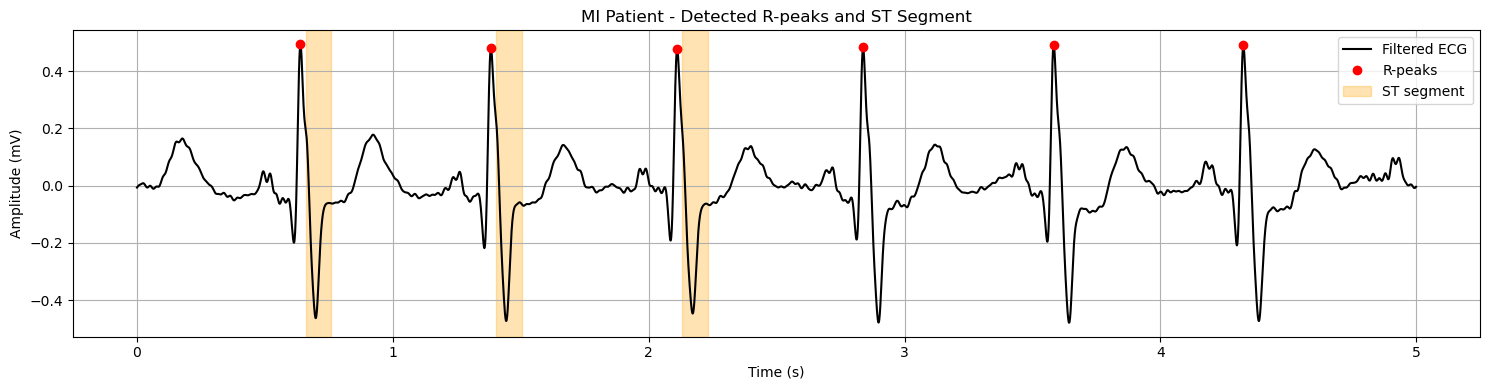

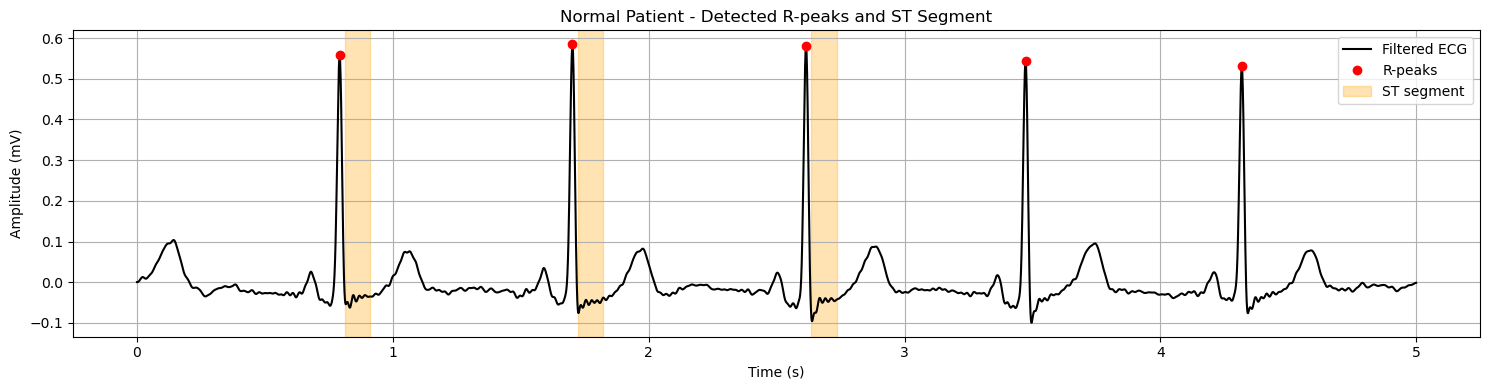

In [23]:
from biosppy.signals import ecg
import matplotlib.pyplot as plt

# Select 5-second signal segment
fs = 1000
mi_signal = df_mi[df_mi['label'] == 1].iloc[0]['signal'][:5*fs]
normal_signal = df_healthy[df_healthy['label'] == 0].iloc[0]['signal'][:5*fs]

def analyze_ecg(signal, fs, title):
    out = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
    
    rpeaks = out['rpeaks']
    ts = out['ts']
    filtered = out['filtered']
    
    plt.figure(figsize=(15, 4))
    plt.plot(ts, filtered, label='Filtered ECG', color='black')
    plt.plot(ts[rpeaks], filtered[rpeaks], 'ro', label='R-peaks')

    # ST segment (example: 20ms after R to 120ms after R)
    for r in rpeaks[:3]:  # only show first 3 for clarity
        st_start = r + int(0.02 * fs)
        st_end = r + int(0.12 * fs)
        if st_end < len(signal):
            plt.axvspan(ts[st_start], ts[st_end], color='orange', alpha=0.3, label='ST segment' if r == rpeaks[0] else "")

    plt.title(f"{title} - Detected R-peaks and ST Segment")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Analyze MI and normal samples
analyze_ecg(mi_signal, fs, "MI Patient")
analyze_ecg(normal_signal, fs, "Normal Patient")


In [24]:
# %pip install biosppy


In [25]:
# %pip install peakutils

In [26]:
#print(X)
#print(y)
# X.shape

In [27]:
#%pip install torchsummary

## Signals sample rate = 250Hz and 500Hz

In [31]:
import pandas as pd
from scipy.signal import resample_poly

In [32]:
''' 
Downsampling Code
'''

def downsample_df_ecg(df, col='signal', down=_):
    downsampled_signal = resample_poly(df[col].values, up=1, down=down)
    new_time_index = df.index[::down][:len(downsampled_signal)]
    return pd.DataFrame({col: downsampled_signal}, index=new_time_index)

In [33]:
''' 
MI Signal downsampled to 250Hz
'''

df_mi_250Hz = df_mi.copy()
df_mi_250Hz['signal'] = df_mi['signal'].apply(lambda x: resample_poly(x, up=1, down=4))

In [34]:
df_mi_250Hz['signal'].apply(len).min()
#df_mi['signal'].apply(len).max()

8000

In [35]:
df_healthy['signal'].apply(len).max()

120012

In [36]:
''' 
Healthy signal downsampled to 250Hz
'''

df_healthy_250Hz = df_healthy.copy()
df_healthy_250Hz['signal'] = df_healthy['signal'].apply(lambda x: resample_poly(x, up=1, down=4))


In [37]:
df_mi_250Hz

,record,signal,label,lead
0,ptbdb_data\patient001\s0010_re,"[-0.15238763828706672, -0.2545316379858563, -0...",1,i
1,ptbdb_data\patient001\s0014lre,"[-0.28497663230576986, -0.50242113407041, -0.4...",1,i
2,ptbdb_data\patient001\s0016lre,"[0.15961924701178928, 0.31903804340142994, 0.2...",1,i
3,ptbdb_data\patient002\s0015lre,"[0.17497509007110418, 0.3440828560478415, 0.34...",1,i
4,ptbdb_data\patient003\s0017lre,"[-0.3897654761197998, -0.6738072910089314, -0....",1,i
...,...,...,...,...
363,ptbdb_data\patient292\s0555_re,"[-0.3203763495659085, -0.5553079256239288, -0....",1,i
364,ptbdb_data\patient292\s0556_re,"[0.5071315435556272, 0.9082201142900356, 0.855...",1,i
365,ptbdb_data\patient293\s0557_re,"[-0.9814429149698869, -1.948126290984725, -1.5...",1,i
366,ptbdb_data\patient293\s0558_re,"[0.38482930880308114, 0.6751676454862325, 0.58...",1,i


In [38]:
df_healthy_250Hz['signal'].apply(len).min()
df_healthy_250Hz

,record,signal,label,lead
0,ptbdb_data\patient104\s0306lre,"[0.018257291326127745, 0.033165106897005164, 0...",0,i
1,ptbdb_data\patient105\s0303lre,"[-0.4122759711772884, -0.7009620846791922, -0....",0,i
2,ptbdb_data\patient116\s0302lre,"[-1.3062180454734424, -2.2655676510205995, -2....",0,i
3,ptbdb_data\patient117\s0291lre,"[-0.11044263655242491, -0.1826057732336871, -0...",0,i
4,ptbdb_data\patient117\s0292lre,"[0.03000174195941121, 0.05811472458026989, 0.0...",0,i
...,...,...,...,...
75,ptbdb_data\patient279\s0533_re,"[-0.23400724082553387, -0.4022238738229594, -0...",0,i
76,ptbdb_data\patient279\s0534_re,"[-0.05317292612670702, -0.09686400919178245, -...",0,i
77,ptbdb_data\patient284\s0543_re,"[-0.11960153515352318, -0.2125365327587412, -0...",0,i
78,ptbdb_data\patient284\s0551_re,"[1.5295694099964934, 2.647838697751852, 2.3458...",0,i


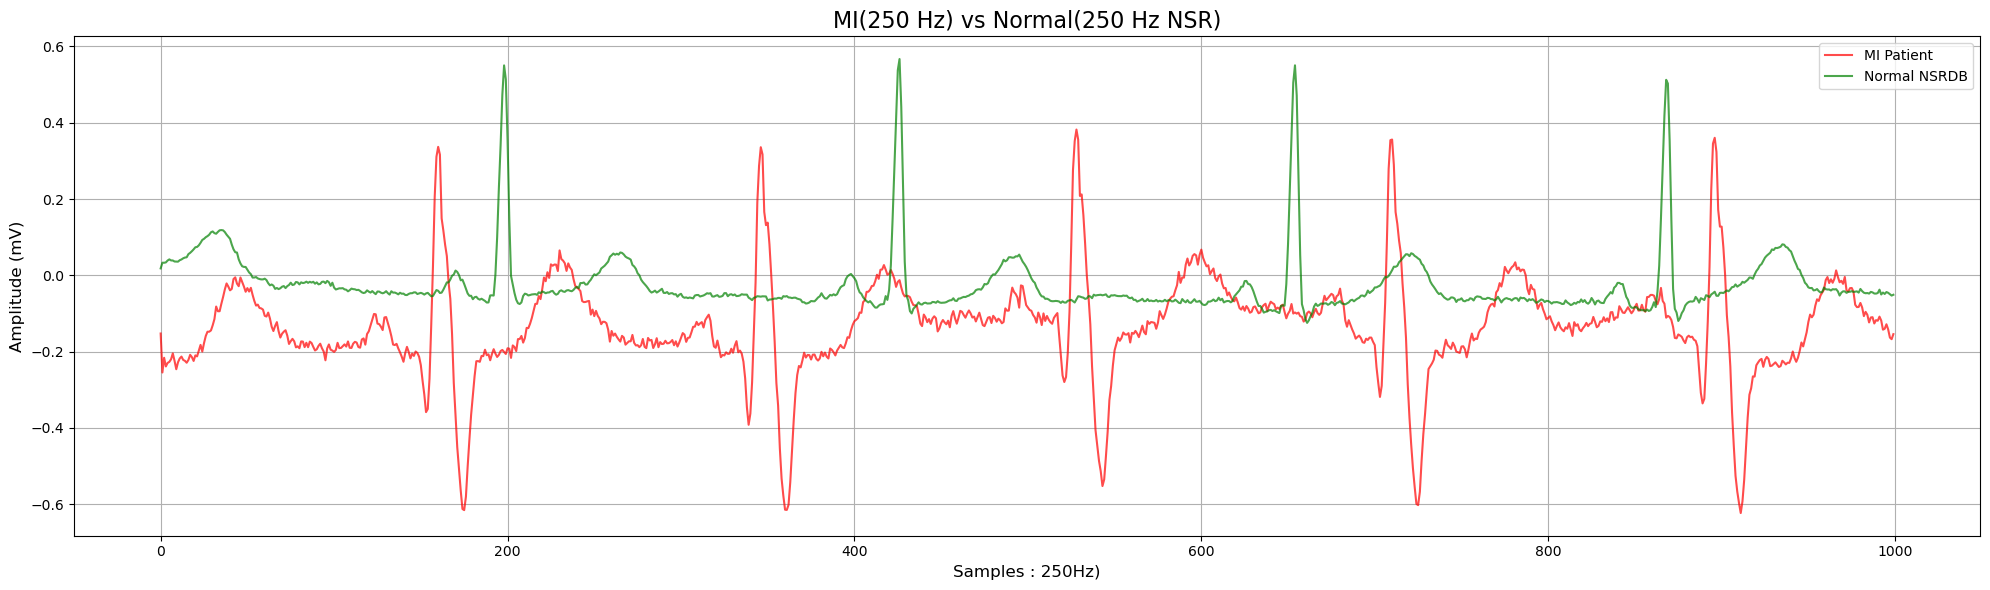

In [39]:
#HERE THE MI SIGNAL

import matplotlib.pyplot as plt

mi_sample = df_mi_250Hz[df_mi_250Hz['label'] == 1].iloc[0]['signal']
normal_sample = df_healthy_250Hz[df_healthy_250Hz['label'] == 0].iloc[0]['signal']
#normal_sample_ptb = df_healthy[df_healthy['label'] == 0].iloc[0]['signal']

mi_sample = mi_sample[:1000]  
normal_sample = normal_sample[:1000] 
#normal_sample_ptb = normal_sample_ptb[:5000]

plt.figure(figsize=(20, 6))
plt.plot(mi_sample, label="MI Patient", color='r', alpha=0.7)
plt.plot(normal_sample, label="Normal NSRDB", color='g', alpha=0.7)
#plt.plot(normal_sample_ptb, label = "Normal PTBDB", color = 'b', alpha = 0.7)

plt.title("MI(250 Hz) vs Normal(250 Hz NSR)", fontsize=16)
plt.xlabel("Samples : 250Hz)", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
df_nsr

,record,signal,label,lead
84043,nsrdb_data\17052,"[1.585, 0.485, -0.715, -0.505, -0.165, -0.105,...",0,ECG1
14556,nsrdb_data\16272,"[-0.055, -0.055, -0.045, -0.045, -0.045, -0.04...",0,ECG1
122955,nsrdb_data\19088,"[-0.03, -0.03, -0.03, -0.03, -0.03, -0.03, -0....",0,ECG1
92620,nsrdb_data\17453,"[-0.095, -0.085, -0.135, -0.125, -0.155, -0.15...",0,ECG1
96706,nsrdb_data\17453,"[-0.07, -0.08, -0.07, -0.07, -0.07, -0.07, -0....",0,ECG1
...,...,...,...,...
19031,nsrdb_data\16273,"[-0.045, -0.045, -0.065, -0.085, -0.095, -0.06...",0,ECG1
3621,nsrdb_data\16265,"[-0.085, -0.095, -0.105, -0.105, -0.115, -0.12...",0,ECG1
5055,nsrdb_data\16265,"[2.925, 2.965, 2.595, 0.985, -0.355, -0.385, -...",0,ECG1
104692,nsrdb_data\18177,"[-0.125, -0.145, -0.125, -0.125, -0.085, -0.05...",0,ECG1


In [41]:
from scipy.signal import resample_poly

# Upsampling factor: 250 / 128 ≈ 1.953125
# So we use integers: up = 250, down = 128

def upsample_signal(signal_array, up=250, down=128):
    return resample_poly(signal_array, up=up, down=down)

# Apply to each row in your DataFrame
df_nsr_250Hz = df_nsr.copy()
df_nsr_250Hz['signal'] = df_nsr_250Hz['signal'].apply(lambda x: upsample_signal(x))


In [42]:
df_nsr_250Hz['signal'].apply(len).max()

2500

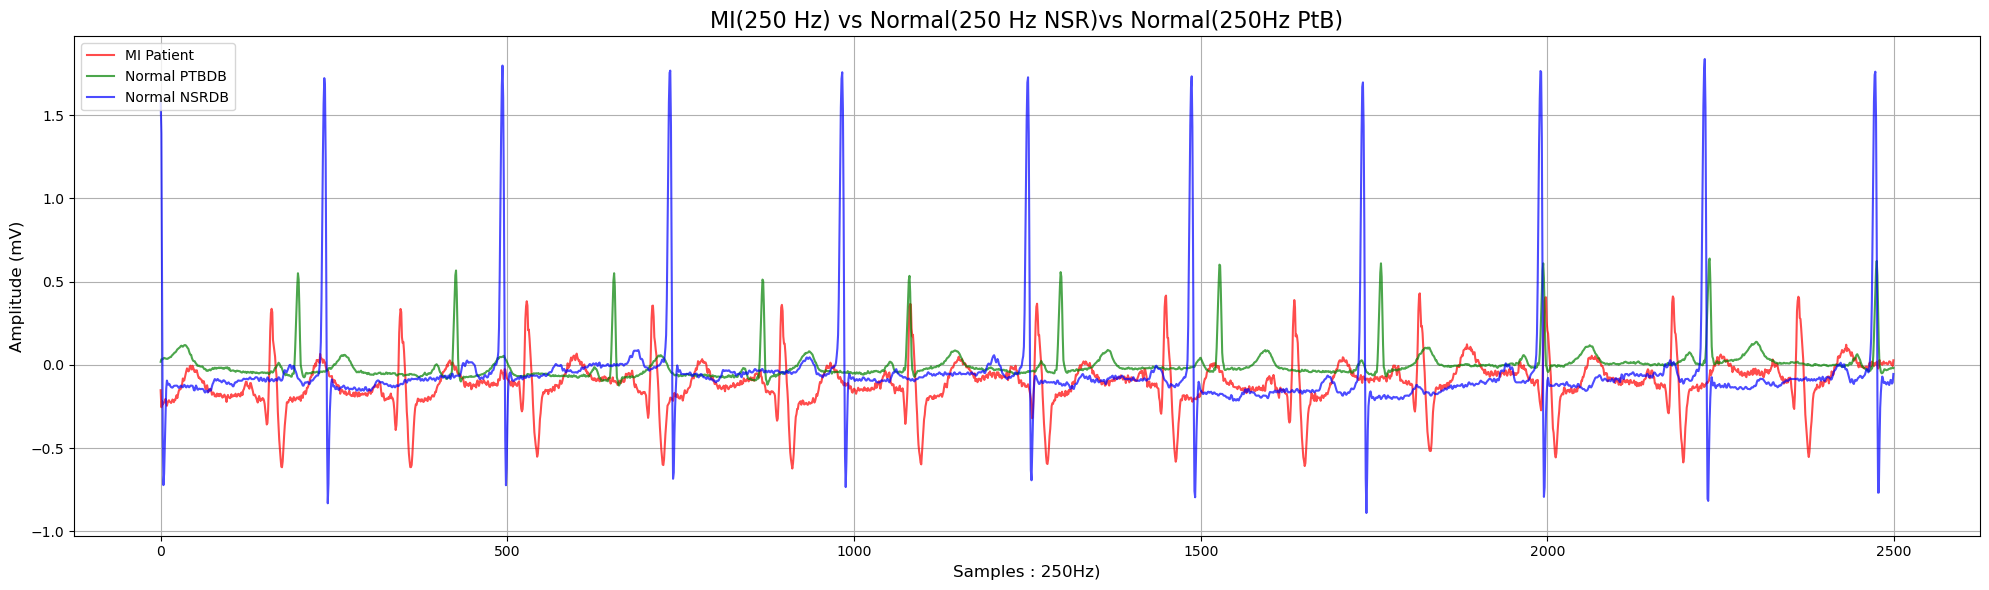

In [43]:

import matplotlib.pyplot as plt

mi_sample = df_mi_250Hz[df_mi_250Hz['label'] == 1].iloc[0]['signal']
normal_sample = df_healthy_250Hz[df_healthy_250Hz['label'] == 0].iloc[0]['signal']
normal_sample_nsr = df_nsr_250Hz[df_nsr_250Hz['label'] == 0].iloc[0]['signal']

mi_sample = mi_sample[:2500]  
normal_sample = normal_sample[:2500] 
normal_sample_nsr = normal_sample_nsr[:2500]

plt.figure(figsize=(20, 6))
plt.plot(mi_sample, label="MI Patient", color='r', alpha=0.7)
plt.plot(normal_sample, label="Normal PTBDB", color='g', alpha=0.7)
plt.plot(normal_sample_nsr, label = "Normal NSRDB", color = 'b', alpha = 0.7)

plt.title("MI(250 Hz) vs Normal(250 Hz NSR)vs Normal(250Hz PtB)", fontsize=16)
plt.xlabel("Samples : 250Hz)", fontsize=12)
plt.ylabel("Amplitude (mV)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [44]:
df_mi_250Hz

,record,signal,label,lead
0,ptbdb_data\patient001\s0010_re,"[-0.15238763828706672, -0.2545316379858563, -0...",1,i
1,ptbdb_data\patient001\s0014lre,"[-0.28497663230576986, -0.50242113407041, -0.4...",1,i
2,ptbdb_data\patient001\s0016lre,"[0.15961924701178928, 0.31903804340142994, 0.2...",1,i
3,ptbdb_data\patient002\s0015lre,"[0.17497509007110418, 0.3440828560478415, 0.34...",1,i
4,ptbdb_data\patient003\s0017lre,"[-0.3897654761197998, -0.6738072910089314, -0....",1,i
...,...,...,...,...
363,ptbdb_data\patient292\s0555_re,"[-0.3203763495659085, -0.5553079256239288, -0....",1,i
364,ptbdb_data\patient292\s0556_re,"[0.5071315435556272, 0.9082201142900356, 0.855...",1,i
365,ptbdb_data\patient293\s0557_re,"[-0.9814429149698869, -1.948126290984725, -1.5...",1,i
366,ptbdb_data\patient293\s0558_re,"[0.38482930880308114, 0.6751676454862325, 0.58...",1,i


In [45]:
#combine the dataset now, 368 entries for mi patients, 80 + 420 for normal patients

ecg_data_250Hz = pd.concat([df_mi_250Hz, df_healthy_250Hz, df_nsr_250Hz], ignore_index=True)

# Shuffle the dataset
ecg_data_250Hz = ecg_data.sample(frac=1, random_state=42).reset_index(drop=True)
ecg_data_250Hz

,record,signal,label,lead
0,ptbdb_data\patient049\s0314lre,"[-0.2665, -0.2775, -0.2775, -0.2815, -0.2795, ...",1,i
1,ptbdb_data\patient030\s0117lre,"[-0.185, -0.191, -0.1985, -0.203, -0.2, -0.189...",1,i
2,nsrdb_data\17453,"[-0.205, -0.205, -0.175, -0.155, -0.205, -0.16...",0,ECG1
3,nsrdb_data\16483,"[0.045, -0.015, -0.105, -0.135, -0.145, -0.135...",0,ECG1
4,nsrdb_data\16483,"[0.145, 0.195, 0.235, 0.285, 0.325, 0.385, 0.4...",0,ECG1
...,...,...,...,...
943,nsrdb_data\19088,"[0.155, 0.075, 0.015, -0.035, -0.075, -0.095, ...",0,ECG1
944,nsrdb_data\19830,"[-0.035, -0.055, -0.065, -0.085, -0.105, -0.11...",0,ECG1
945,nsrdb_data\16420,"[-0.205, -0.205, -0.215, -0.205, -0.215, -0.21...",0,ECG1
946,nsrdb_data\19830,"[-0.295, -0.285, -0.275, -0.255, -0.245, -0.21...",0,ECG1


In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def pad_or_truncate(sig, length=2500):
    sig = np.array(sig)
    if len(sig) < length:
        pad = np.zeros(length - len(sig))
        return np.concatenate([sig, pad])
    return sig[:length]

ecg_data_250Hz['signal'] = ecg_data_250Hz['signal'].apply(lambda x: pad_or_truncate(x, 2500))
X = np.stack(ecg_data_250Hz['signal'].values)
y = ecg_data_250Hz['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 2500)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [48]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (758, 2500)
X_val shape: (95, 2500)
X_test shape: (95, 2500)


In [49]:
import torch
import torch.nn as nn

class ECG_CNN_250Hz(nn.Module):
    def __init__(self):
        super(ECG_CNN_250Hz, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=15, padding=7)  # qrs complex duration
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2) 
        self.flatten_size = 64 * 2500  
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 2)  

    def forward(self, x):
        x = self.relu(self.conv1(x))         # op shape: (B, 32, 2500)
        x = self.relu(self.conv2(x))         # op shape: (B, 64, 2500)
        x = x.view(x.size(0), -1)            # flatten: (B, 64*2500)
        x = self.relu(self.fc1(x))           # fc layer
        return self.fc2(x)                   


In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Training loop
def train_model(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_preds, train_targets = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            train_preds += torch.argmax(output, dim=1).tolist()
            train_targets += yb.tolist()

        train_acc = accuracy_score(train_targets, train_preds)

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                val_preds += torch.argmax(output, dim=1).tolist()
                val_targets += yb.tolist()
        val_acc = accuracy_score(val_targets, val_preds)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Test
    test_preds, test_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            test_preds += torch.argmax(output, dim=1).tolist()
            test_targets += yb.tolist()
    test_acc = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

# Train
model = ECG_CNN_250Hz()
train_model(model, train_loader, val_loader, test_loader)



Epoch 1: Train Acc = 0.7810, Val Acc = 0.8211
Epoch 2: Train Acc = 0.8773, Val Acc = 0.8947
Epoch 3: Train Acc = 0.8931, Val Acc = 0.8947
Epoch 4: Train Acc = 0.9011, Val Acc = 0.8842
Epoch 5: Train Acc = 0.9156, Val Acc = 0.9053
Epoch 6: Train Acc = 0.9063, Val Acc = 0.9053
Epoch 7: Train Acc = 0.9169, Val Acc = 0.9053
Epoch 8: Train Acc = 0.9222, Val Acc = 0.9053
Epoch 9: Train Acc = 0.9248, Val Acc = 0.9053
Epoch 10: Train Acc = 0.9301, Val Acc = 0.9053
Test Accuracy: 0.8947


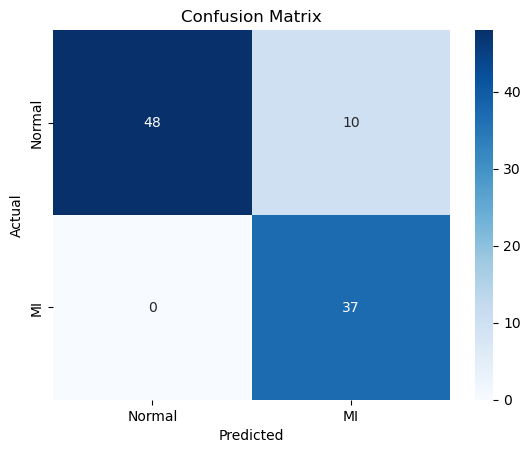

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        if isinstance(outputs, tuple):  # in case model returns (logits, other_outputs)
            outputs = outputs[0]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Normal', 'MI']  # Change according to your classes
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
from torchinfo import summary

model = ECG_CNN_250Hz()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(1, 1, 2500))


Layer (type:depth-idx)                   Output Shape              Param #
ECG_CNN_250Hz                            [1, 2]                    --
├─Conv1d: 1-1                            [1, 32, 2500]             512
├─ReLU: 1-2                              [1, 32, 2500]             --
├─Conv1d: 1-3                            [1, 64, 2500]             10,304
├─ReLU: 1-4                              [1, 64, 2500]             --
├─Linear: 1-5                            [1, 128]                  20,480,128
├─ReLU: 1-6                              [1, 128]                  --
├─Linear: 1-7                            [1, 2]                    258
Total params: 20,491,202
Trainable params: 20,491,202
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 47.52
Input size (MB): 0.01
Forward/backward pass size (MB): 1.92
Params size (MB): 81.96
Estimated Total Size (MB): 83.90

## Signnal sample rate = 500 Hz

In [53]:
import pandas as pd
from scipy.signal import resample_poly

In [54]:
def downsample_df_ecg(df, col='signal', down=_):
    downsampled_signal = resample_poly(df[col].values, up=1, down=down)
    new_time_index = df.index[::down][:len(downsampled_signal)]
    return pd.DataFrame({col: downsampled_signal}, index=new_time_index)

In [55]:
''' 
Healthy and MI signals from ptbdb
'''

df_healthy_500Hz = df_healthy.copy()
df_healthy_500Hz['signal'] = df_healthy['signal'].apply(lambda x: resample_poly(x, up=1, down=2))

df_mi_500Hz = df_mi.copy()
df_mi_500Hz['signal'] = df_mi['signal'].apply(lambda x: resample_poly(x, up=1, down=2))


In [56]:
def upsample_signal(signal_array, up=500, down=128):
    return resample_poly(signal_array, up=up, down=down)

# Apply to each row in your DataFrame
df_nsr_500Hz = df_nsr.copy()
df_nsr_500Hz['signal'] = df_nsr_500Hz['signal'].apply(lambda x: upsample_signal(x))
df_nsr_500Hz


,record,signal,label,lead
84043,nsrdb_data\17052,"[1.5860700330009727, 1.6240386996910452, 1.392...",0,ECG1
14556,nsrdb_data\16272,"[-0.0550371304826836, -0.06203733099030115, -0...",0,ECG1
122955,nsrdb_data\19088,"[-0.030020252990554688, -0.03359642282920687, ...",0,ECG1
92620,nsrdb_data\17453,"[-0.09506413447008985, -0.1000283876856729, -0...",0,ECG1
96706,nsrdb_data\17453,"[-0.07004725697796095, -0.0814981981646703, -0...",0,ECG1
...,...,...,...,...
19031,nsrdb_data\16273,"[-0.04503037948583204, -0.04870234457905176, -...",0,ECG1
3621,nsrdb_data\16265,"[-0.0850573834732383, -0.09698726313847073, -0...",0,ECG1
5055,nsrdb_data\16265,"[2.926974666579082, 3.278807175337093, 3.32447...",0,ECG1
104692,nsrdb_data\18177,"[-0.12508438746064454, -0.14673244650769712, -...",0,ECG1


In [57]:
ecg_data_500Hz = pd.concat([df_mi_500Hz, df_healthy_500Hz, df_nsr_500Hz], ignore_index=True)

# Shuffle the dataset
ecg_data_500Hz = ecg_data.sample(frac=1, random_state=42).reset_index(drop=True)
ecg_data_500Hz

,record,signal,label,lead
0,ptbdb_data\patient049\s0314lre,"[-0.2665, -0.2775, -0.2775, -0.2815, -0.2795, ...",1,i
1,ptbdb_data\patient030\s0117lre,"[-0.185, -0.191, -0.1985, -0.203, -0.2, -0.189...",1,i
2,nsrdb_data\17453,"[-0.205, -0.205, -0.175, -0.155, -0.205, -0.16...",0,ECG1
3,nsrdb_data\16483,"[0.045, -0.015, -0.105, -0.135, -0.145, -0.135...",0,ECG1
4,nsrdb_data\16483,"[0.145, 0.195, 0.235, 0.285, 0.325, 0.385, 0.4...",0,ECG1
...,...,...,...,...
943,nsrdb_data\19088,"[0.155, 0.075, 0.015, -0.035, -0.075, -0.095, ...",0,ECG1
944,nsrdb_data\19830,"[-0.035, -0.055, -0.065, -0.085, -0.105, -0.11...",0,ECG1
945,nsrdb_data\16420,"[-0.205, -0.205, -0.215, -0.205, -0.215, -0.21...",0,ECG1
946,nsrdb_data\19830,"[-0.295, -0.285, -0.275, -0.255, -0.245, -0.21...",0,ECG1


In [58]:
df_nsr_500Hz['signal'].apply(len).max()

5000

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def pad_or_truncate(sig, length=5000):
    sig = np.array(sig)
    if len(sig) < length:
        pad = np.zeros(length - len(sig))
        return np.concatenate([sig, pad])
    return sig[:length]

ecg_data_500Hz['signal'] = ecg_data_500Hz['signal'].apply(lambda x: pad_or_truncate(x, 5000))
X = np.stack(ecg_data_500Hz['signal'].values)
y = ecg_data_500Hz['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [60]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 2500)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


In [61]:
import torch
import torch.nn as nn

class ECG_CNN_500Hz(nn.Module):
    def __init__(self):
        super(ECG_CNN_500Hz, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=15, padding=7)  # qrs duration
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)  
        self.flatten_size = 64 * 5000
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.fc2 = nn.Linear(256, 2)  

    def forward(self, x):
        x = self.relu(self.conv1(x))         # op shape: (B, 32, 2500)
        x = self.relu(self.conv2(x))         # op shape: (B, 64, 2500)
        x = x.view(x.size(0), -1)            # flatten: (B, 64*2500)
        x = self.relu(self.fc1(x))           # fc
        return self.fc2(x)                    


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Training loop
def train_model(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_preds, train_targets = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            train_preds += torch.argmax(output, dim=1).tolist()
            train_targets += yb.tolist()

        train_acc = accuracy_score(train_targets, train_preds)

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                val_preds += torch.argmax(output, dim=1).tolist()
                val_targets += yb.tolist()
        val_acc = accuracy_score(val_targets, val_preds)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Test
    test_preds, test_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            test_preds += torch.argmax(output, dim=1).tolist()
            test_targets += yb.tolist()
    test_acc = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

# Train
model = ECG_CNN_500Hz()
train_model(model, train_loader, val_loader, test_loader)



Epoch 1: Train Acc = 0.7414, Val Acc = 0.7579
Epoch 2: Train Acc = 0.8509, Val Acc = 0.8526
Epoch 3: Train Acc = 0.8760, Val Acc = 0.8842
Epoch 4: Train Acc = 0.9090, Val Acc = 0.8737
Epoch 5: Train Acc = 0.9103, Val Acc = 0.8842
Epoch 6: Train Acc = 0.9142, Val Acc = 0.8737
Epoch 7: Train Acc = 0.9142, Val Acc = 0.8526
Epoch 8: Train Acc = 0.9235, Val Acc = 0.8421
Epoch 9: Train Acc = 0.9235, Val Acc = 0.8737
Epoch 10: Train Acc = 0.9472, Val Acc = 0.8947
Test Accuracy: 0.8947


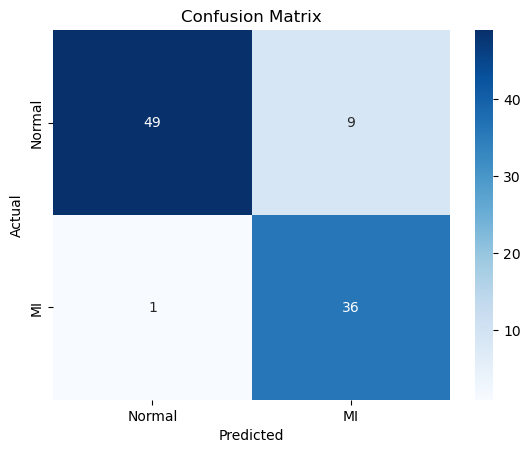

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        if isinstance(outputs, tuple):  # in case model returns (logits, other_outputs)
            outputs = outputs[0]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Normal', 'MI']  
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [64]:
#%pip install torchinfo

In [65]:
from torchinfo import summary

model = ECG_CNN_500Hz()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(1, 1, 5000))


Layer (type:depth-idx)                   Output Shape              Param #
ECG_CNN_500Hz                            [1, 2]                    --
├─Conv1d: 1-1                            [1, 32, 5000]             512
├─ReLU: 1-2                              [1, 32, 5000]             --
├─Conv1d: 1-3                            [1, 64, 5000]             10,304
├─ReLU: 1-4                              [1, 64, 5000]             --
├─Linear: 1-5                            [1, 256]                  81,920,256
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 2]                    514
Total params: 81,931,586
Trainable params: 81,931,586
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 136.00
Input size (MB): 0.02
Forward/backward pass size (MB): 3.84
Params size (MB): 327.73
Estimated Total Size (MB): 331.59

## trying Wavelet Tranformation : sym4

In [66]:
%pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [67]:
import pywt
from scipy.signal import resample

def apply_wavelet_transform(df, wavelet='sym4', level=3, col='signal', target_len=None):
    approx_signals = []
    for sig in df[col]:
        coeffs = pywt.wavedec(sig, wavelet, level=level) # it has [a3, d3, d2, d1]
        approx = coeffs[0] 
        if target_len:
            approx = resample(approx, target_len) 
        approx_signals.append(approx)
    df_wave = df.copy()
    df_wave[col] = approx_signals
    return df_wave


In [68]:
temp_lengths = []
for df in [df_mi_500Hz, df_healthy_500Hz, df_nsr_500Hz]:
    for sig in df['signal']:
        temp_lengths.append(len(pywt.wavedec(sig, 'sym4', level=3)[0]))
max_len = max(temp_lengths)  

df_mi_wavelet = apply_wavelet_transform(df_mi_500Hz, wavelet='sym4', level=3, target_len=max_len)
df_healthy_wavelet = apply_wavelet_transform(df_healthy_500Hz, wavelet='sym4', level=3, target_len=max_len)
df_nsr_wavelet = apply_wavelet_transform(df_nsr_500Hz, wavelet='sym4', level=3, target_len=max_len)


In [69]:
print(len(df_mi_wavelet['signal'].iloc[0])) 

7506


In [76]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df_combined = pd.concat([df_healthy_wavelet, df_mi_wavelet, df_nsr_wavelet])
X = np.array(df_combined['signal'].tolist())
y = LabelEncoder().fit_transform(df_combined['label'])  

from scipy.signal import resample
target_len = max(len(sig) for sig in X)
X_padded = np.array([resample(sig, target_len) for sig in X])

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [77]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def build_loader(X, y, batch_size=32):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=True)

train_loader = build_loader(X_train, y_train)
val_loader = build_loader(X_val, y_val)
test_loader = build_loader(X_test, y_test)


In [78]:
import torch.nn as nn

class Wavelet_ECG_CNN(nn.Module):
    def __init__(self, input_len):
        super(Wavelet_ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * input_len, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [79]:
model = Wavelet_ECG_CNN(input_len=target_len)

from torch import optim
from sklearn.metrics import accuracy_score

def train_model(model, train_loader, val_loader, test_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        all_preds, all_targets = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            all_preds += torch.argmax(out, dim=1).tolist()
            all_targets += yb.tolist()
        train_acc = accuracy_score(all_targets, all_preds)

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                val_preds += torch.argmax(out, dim=1).tolist()
                val_targets += yb.tolist()
        val_acc = accuracy_score(val_targets, val_preds)

        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Test
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            test_preds += torch.argmax(out, dim=1).tolist()
            test_targets += yb.tolist()
    test_acc = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

train_model(model, train_loader, val_loader, test_loader)


Epoch 1: Train Acc = 0.6570, Val Acc = 0.7474
Epoch 2: Train Acc = 0.8034, Val Acc = 0.8737
Epoch 3: Train Acc = 0.8945, Val Acc = 0.8947
Epoch 4: Train Acc = 0.8958, Val Acc = 0.8842
Epoch 5: Train Acc = 0.9129, Val Acc = 0.8526
Epoch 6: Train Acc = 0.9116, Val Acc = 0.8842
Epoch 7: Train Acc = 0.9274, Val Acc = 0.8842
Epoch 8: Train Acc = 0.9314, Val Acc = 0.8632
Epoch 9: Train Acc = 0.9446, Val Acc = 0.8842
Epoch 10: Train Acc = 0.9485, Val Acc = 0.8632
Test Accuracy: 0.9263


## Trying DNN

In [74]:
import torch
import torch.nn as nn

class ECG_DNN(nn.Module):
    def __init__(self, input_size=5000):
        super(ECG_DNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512), 
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),         
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),         
            nn.ReLU(),
            nn.Linear(128, 2)            
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.model(x)


In [75]:
def train_dnn(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_preds, train_targets = [], []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            train_preds += torch.argmax(output, dim=1).tolist()
            train_targets += yb.tolist()

        train_acc = accuracy_score(train_targets, train_preds)

        # Validation
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                val_preds += torch.argmax(output, dim=1).tolist()
                val_targets += yb.tolist()

        val_acc = accuracy_score(val_targets, val_preds)
        print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Test
    test_preds, test_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            test_preds += torch.argmax(output, dim=1).tolist()
            test_targets += yb.tolist()
    test_acc = accuracy_score(test_targets, test_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)

model = ECG_DNN(input_size=5000)
train_dnn(model, train_loader, val_loader, test_loader)


Epoch 1: Train Acc = 0.7309, Val Acc = 0.8842
Epoch 2: Train Acc = 0.8760, Val Acc = 0.8105
Epoch 3: Train Acc = 0.8430, Val Acc = 0.8632
Epoch 4: Train Acc = 0.8826, Val Acc = 0.8842
Epoch 5: Train Acc = 0.9090, Val Acc = 0.8737
Epoch 6: Train Acc = 0.8997, Val Acc = 0.8737
Epoch 7: Train Acc = 0.9169, Val Acc = 0.8737
Epoch 8: Train Acc = 0.9182, Val Acc = 0.8737
Epoch 9: Train Acc = 0.9182, Val Acc = 0.8842
Epoch 10: Train Acc = 0.9208, Val Acc = 0.8737
Test Accuracy: 0.8737


## Model Comparison – Test Accuracy

| Model                          | Sampling Rate | Preprocessing         | Test Accuracy |
|-------------------------------|----------------|------------------------|---------------|
| 1D CNN                        | 250 Hz         | Raw                    | ~89%          |
| 1D CNN                        | 500 Hz         | Raw                    | ~89%          |
| 1D CNN + Wavelet (sym4)       | 500 Hz         | Wavelet (level=3)      | ~92%          |
| Deep Neural Network (DNN)     | 500 Hz         | Flattened Input (Raw)  | ~87%          |
